# Import

In [1]:
import os
import sys
import types
from itertools import islice
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
sys.path.append('../../')

In [3]:
from fiducial_detect.data import *
from fiducial_detect.models import *

# Utility

In [4]:
def save_checkpoint(model, optimizer, metrics, file_checkpoint):
    file_checkpoint.parent.mkdir(exist_ok=True)
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'metrics': metrics},
               file_checkpoint)

In [5]:
def load_checkpoint(model, optimizer, file_checkpoint):
    checkpoint = torch.load(file_checkpoint)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    metrics = checkpoint['metrics']
    return model, optimizer, metrics

In [6]:
def train(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Train for an epoch
    model.train()
    for X, y in dl:
        X, y = X.to(device), y.to(device)
        
        # Optimize
        optimizer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        
        # Get metrics scaled by batch size
        for key, metric in metrics.items():
            m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size
           
        # Track total number of items
        total_items += X.shape[0]
        
    # Get mean of metrics
    for key, metric in metrics.items():
        m[key] /= total_items
        
    return m

In [7]:
def validate(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Validate
    model.eval()
    with torch.no_grad():
        for X, y in dl:
            X, y = X.to(device), y.to(device)

            y_hat = model(X)

            # Get metrics scaled by batch size
            for key, metric in metrics.items():
                m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size

            # Track total number of items
            total_items += X.shape[0]

        # Get mean of metrics
        for key, metric in metrics.items():
            m[key] /= total_items

    return m

# Metrics

In [8]:
class MetricAccuracy():
    def __call__(self, y_hat, y):
        return (y_hat.argmax(dim=1) == y).float().mean().item()

In [9]:
class MetricErrorRate():
    def __call__(self, y_hat, y):
        return 1 - MetricAccuracy()(y_hat, y)

# Train

In [10]:
# Config
batch_size = 28
num_workers = 4
pin_memory = True
num_batches = 20
num_epochs = 500
lr = 1e-3
schedule = False

# Device
device = torch.device('cuda')

# Loss
loss = nn.functional.cross_entropy

# Metrics
metrics = {}
metrics['loss'] = lambda y_hat, y: loss(y_hat, y).item()
metrics['err'] = MetricErrorRate()

# Checkpoint metric
metric_checkpoint = 'err'

# Model
in_channels  = 1
out_channels = 5
layout_encoder = [[[48,5,2,2]],
                  [[48,3,1,1],[48,3,2,1]],
                  [[60,3,1,1],[60,3,2,1]],
                  [[72,3,1,1],[144,3,2,1]]]
model = UNET(get_encoder(in_channels, layout_encoder), out_channels)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [11]:
tfms_trn = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    RandomContrast((0.5, 1.5), 1, 0.33),
                    RandomBrightness((-0.5, 0.5), 0, 0.33),
                    RandomBlur((0, 1.5), 0.50, 0.50),
                    Random(Noise((-0.25, 0.25), 0, 0.1), 0.9),
                    Random(RandomGrad((-0.5, 0.5))     , 0.9),
                    Clip((-1,1)),
                    ToTensor()])

dl_trn = IsliceDataloader(num_batches,
                          SyntheticMaskDataSet(dir_random_bg=Path('../../data/backgrounds'), tfms=tfms_trn), 
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=pin_memory, 
                          worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

In [12]:
tfms_val = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    ToTensor()])

dl_val = DataLoader(RealMaskDataSet(Path('../../data/ground_truth'), tfms=tfms_val), 
                    batch_size=batch_size,
                    num_workers=num_workers,
                    pin_memory=pin_memory, 
                    worker_init_fn=lambda wid: np.random.seed(np.mod(torch.initial_seed() + wid, 2**32)))

<IPython.core.display.Javascript object>


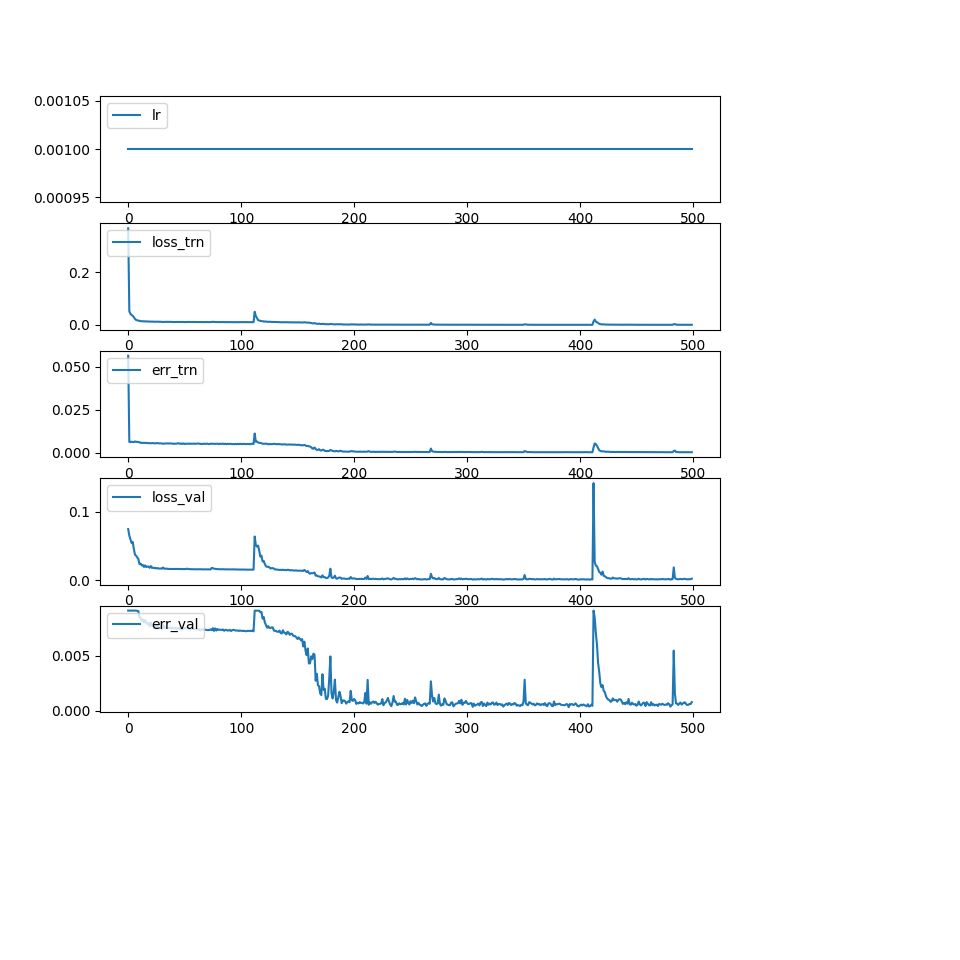

            lr   loss_trn    err_trn   loss_val    err_val
0      0.00100    0.36843    0.05652    0.07455    0.00909 - err decreased; checkpointing...
1      0.00100    0.05264    0.00620    0.06506    0.00909
2      0.00100    0.04218    0.00612    0.05941    0.00909
3      0.00100    0.03784    0.00631    0.05419    0.00909
4      0.00100    0.03484    0.00623    0.05580    0.00909
5      0.00100    0.02963    0.00608    0.04581    0.00909
6      0.00100    0.02298    0.00650    0.03733    0.00909
7      0.00100    0.01897    0.00621    0.03567    0.00909 - err decreased; checkpointing...
8      0.00100    0.01788    0.00633    0.03331    0.00906 - err decreased; checkpointing...
9      0.00100    0.01619    0.00606    0.03092    0.00904 - err decreased; checkpointing...
10     0.00100    0.01585    0.00613    0.02330    0.00851 - err decreased; checkpointing...
11     0.00100    0.01442    0.00563    0.02421    0.00843 - err decreased; checkpointing...
12     0.00100    0.01398    

125    0.00100    0.01231    0.00506    0.01874    0.00751
126    0.00100    0.01181    0.00488    0.01714    0.00750
127    0.00100    0.01151    0.00496    0.01748    0.00756
128    0.00100    0.01125    0.00500    0.01759    0.00755
129    0.00100    0.01155    0.00508    0.01697    0.00727
130    0.00100    0.01130    0.00508    0.01568    0.00724
131    0.00100    0.01086    0.00495    0.01569    0.00723
132    0.00100    0.01067    0.00484    0.01540    0.00717 - err decreased; checkpointing...
133    0.00100    0.01089    0.00503    0.01526    0.00716 - err decreased; checkpointing...
134    0.00100    0.01040    0.00488    0.01495    0.00727
135    0.00100    0.01032    0.00487    0.01517    0.00705 - err decreased; checkpointing...
136    0.00100    0.01017    0.00468    0.01489    0.00701 - err decreased; checkpointing...
137    0.00100    0.01036    0.00480    0.01536    0.00730
138    0.00100    0.01029    0.00479    0.01480    0.00708
139    0.00100    0.01033    0.00481  

246    0.00100    0.00095    0.00033    0.00133    0.00055
247    0.00100    0.00090    0.00033    0.00263    0.00096
248    0.00100    0.00091    0.00034    0.00164    0.00069
249    0.00100    0.00099    0.00037    0.00136    0.00055
250    0.00100    0.00095    0.00034    0.00196    0.00085
251    0.00100    0.00093    0.00035    0.00167    0.00069
252    0.00100    0.00093    0.00035    0.00232    0.00090
253    0.00100    0.00101    0.00037    0.00164    0.00066
254    0.00100    0.00119    0.00043    0.00294    0.00119
255    0.00100    0.00107    0.00039    0.00210    0.00083
256    0.00100    0.00095    0.00036    0.00134    0.00055
257    0.00100    0.00099    0.00036    0.00177    0.00070
258    0.00100    0.00088    0.00033    0.00128    0.00053
259    0.00100    0.00085    0.00032    0.00125    0.00048
260    0.00100    0.00090    0.00034    0.00110    0.00041
261    0.00100    0.00095    0.00036    0.00136    0.00053
262    0.00100    0.00088    0.00033    0.00145    0.000

384    0.00100    0.00058    0.00023    0.00133    0.00051
385    0.00100    0.00057    0.00023    0.00124    0.00049
386    0.00100    0.00064    0.00024    0.00120    0.00048
387    0.00100    0.00059    0.00023    0.00119    0.00050
388    0.00100    0.00053    0.00021    0.00152    0.00059
389    0.00100    0.00054    0.00020    0.00142    0.00055
390    0.00100    0.00050    0.00020    0.00071    0.00030 - err decreased; checkpointing...
391    0.00100    0.00051    0.00020    0.00156    0.00058
392    0.00100    0.00043    0.00017    0.00140    0.00055
393    0.00100    0.00051    0.00020    0.00154    0.00059
394    0.00100    0.00051    0.00020    0.00125    0.00051
395    0.00100    0.00047    0.00019    0.00131    0.00052
396    0.00100    0.00049    0.00019    0.00184    0.00065
397    0.00100    0.00048    0.00019    0.00140    0.00054
398    0.00100    0.00053    0.00020    0.00093    0.00039
399    0.00100    0.00049    0.00019    0.00090    0.00039
400    0.00100    0.00

In [13]:
%matplotlib notebook

# Training loop
df_metrics = pd.DataFrame(columns=['lr'] + 
                                  [str(key+'_trn') for key in metrics.keys()] +
                                  [str(key+'_val') for key in metrics.keys()])
m_checkpoint = np.inf # Initialize to arbitrarily high value
fig, axs = plt.subplots(df_metrics.shape[1], 1, figsize=(8,8))
for num_epoch in range(num_epochs):    
    # Train
    m_trn = train(model, dl_trn, loss, metrics, optimizer, device)
    
    # Validate
    m_val = validate(model, dl_val, loss, metrics, optimizer, device)
    
    # Step scheduler
    if schedule:
        scheduler.step(m_trn['loss'])
    
    # Store metrics
    df_metrics.loc[num_epoch, 'lr'] = np.mean([p['lr'] for p in optimizer.param_groups])
    for key, val in m_trn.items(): df_metrics.loc[num_epoch, key+'_trn'] = val
    for key, val in m_val.items(): df_metrics.loc[num_epoch, key+'_val'] = val
    
    # Print metrics
    print(df_metrics.iloc[[num_epoch]].to_string(header=num_epoch == 0,
                                                 float_format=lambda x: f'{x:10.5f}',
                                                 col_space=3), end='')
    
    # Checkpoint
    if m_val[metric_checkpoint] < m_checkpoint:
        print(f' - {metric_checkpoint} decreased; checkpointing...', end='')
        save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/best.pth'))
        m_checkpoint = m_val[metric_checkpoint]
        
    # Print newline
    print()
    
    # Plot stuff
    for idx, key in enumerate(df_metrics.columns):
        axs[idx].clear()
        axs[idx].plot(np.arange(num_epoch+1), df_metrics[key], label=key)
        axs[idx].legend(loc='upper left')
    fig.canvas.draw()
    
# Checkpoint last
print(f' - checkpointing last...')
save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/last.pth'))
    
%matplotlib inline

# Test

In [37]:
model, optimizer, _ = load_checkpoint(model, optimizer, 'checkpoints/best.pth')

Inspect training dataset

In [38]:
X, y = next(iter(dl_trn))
X, y = X.to(device), y.to(device)

In [39]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

In [40]:
idx = 0

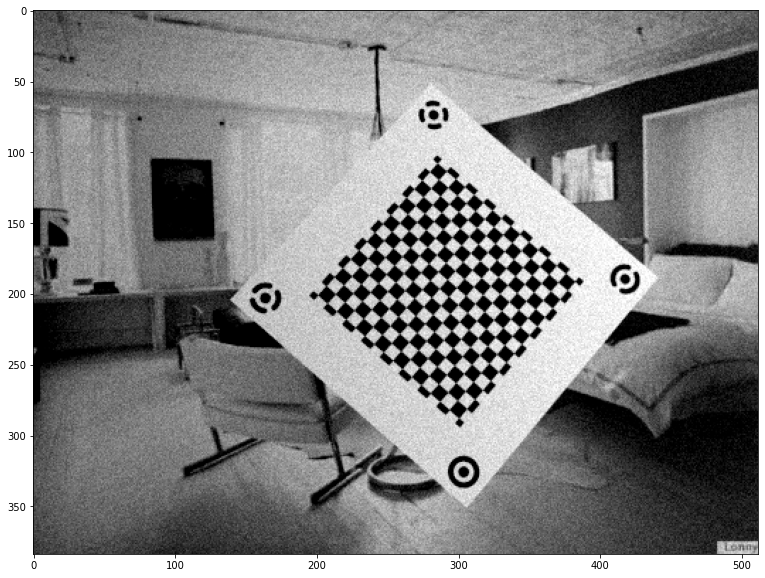

In [41]:
plt.figure(figsize=(15,10))
plt.imshow(X[idx,0,:,:].cpu().detach(), cmap='gray', vmin=-1, vmax=1)

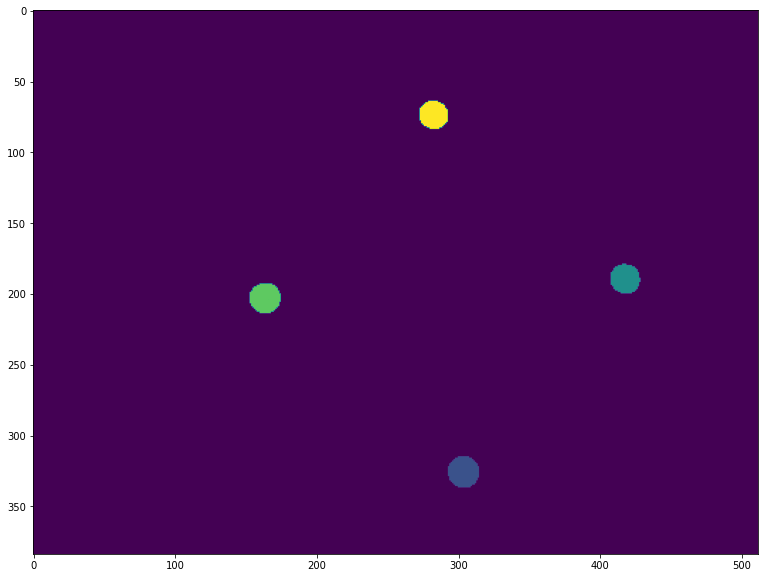

In [42]:
plt.figure(figsize=(15,10))
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx], vmin=0, vmax=4)

Inspect validation training set

In [43]:
X, y = next(iter(dl_val))
X, y = X.to(device), y.to(device)

In [75]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

In [76]:
idx = 0

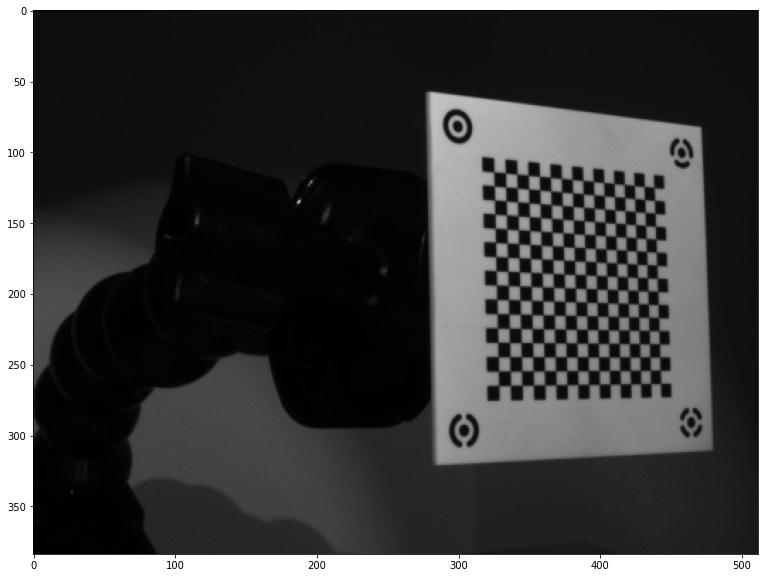

In [77]:
plt.figure(figsize=(15,10))
plt.imshow(X[idx,0,:,:].cpu().detach(), cmap='gray', vmin=-1, vmax=1)

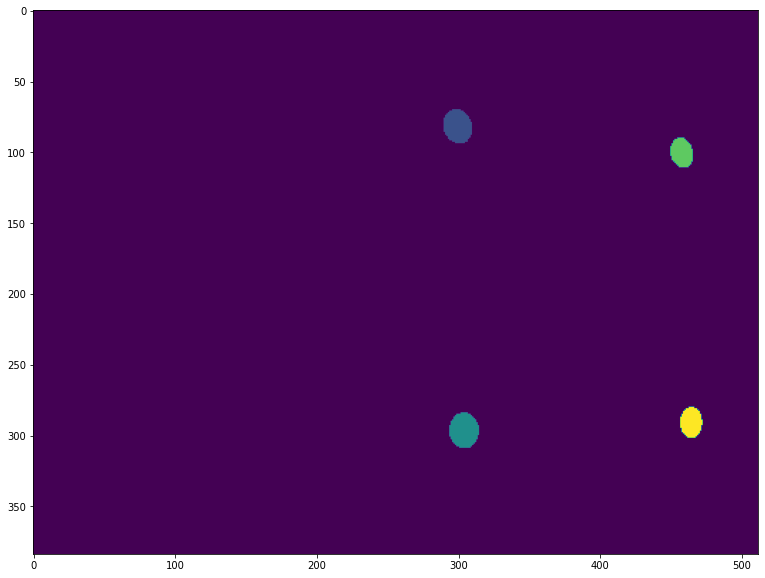

In [78]:
plt.figure(figsize=(15,10))
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx], vmin=0, vmax=4)

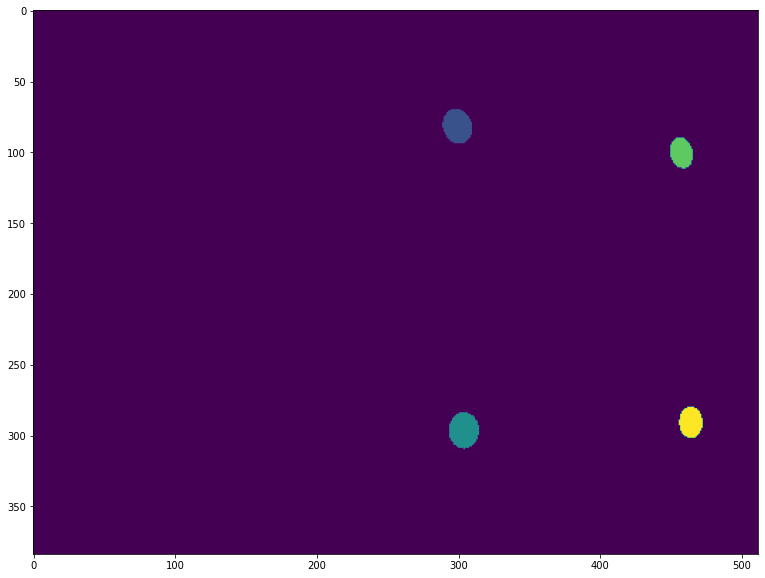

In [79]:
plt.figure(figsize=(15,10))
plt.imshow(y.cpu().detach()[idx], vmin=0, vmax=4)

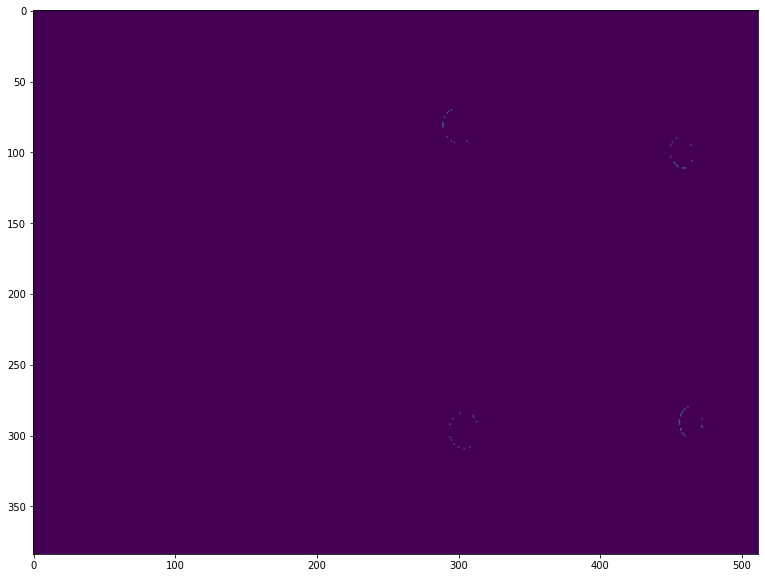

In [80]:
plt.figure(figsize=(15,10))
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx] != y.cpu().detach()[idx], vmin=0, vmax=4)